In [112]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
import joblib
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from lightgbm import LGBMClassifier
from sklearn.metrics import r2_score,mean_squared_error

In [113]:
df=pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [114]:
df.drop(['CustomerID'], axis=1, inplace=True)

In [115]:
encoder=LabelEncoder()
df['Genre'] = encoder.fit_transform(df['Genre'])

In [ ]:
target = df['Spending Score (1-100)']
numeric_cols = df.drop(columns=['Spending Score (1-100)']).select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(df[numeric_cols])
df_scaled = pd.DataFrame(scaled_array, columns=numeric_cols)
df_scaled['Spending Score (1-100)'] = target

In [117]:
df_scaled.describe()


,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,0.440000,0.400962,0.373443,50.200000
std,0.497633,0.268635,0.215285,25.823522
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.206731,0.217213,34.750000
50%,0.000000,0.346154,0.381148,50.000000
75%,1.000000,0.596154,0.516393,73.000000
max,1.000000,1.000000,1.000000,99.000000


In [118]:
df_scaled.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1.0,0.019231,0.000000,39
1,1.0,0.057692,0.000000,81
2,0.0,0.038462,0.008197,6
3,0.0,0.096154,0.008197,77
4,0.0,0.250000,0.016393,40


In [119]:
pca = PCA(n_components=2, random_state=42)
x = pca.fit_transform(df_scaled)
model = KMeans(n_clusters=4, random_state=42)
labels = model.fit_predict(x)
df_scaled['Cluster'] = labels

In [120]:
features = df_scaled.drop('Spending Score (1-100)', axis=1)
target = df_scaled['Spending Score (1-100)']

In [121]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [122]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)

# Parameter grid for tuning
param_grid = {
    'depth': [3,4,6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200],
    'l2_leaf_reg': [1,7,10]
}

# Grid Search with 5-fold CV
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='r2',
    cv=8,
    verbose=1,
    n_jobs=-1
)

# Train model
grid_search.fit(x_train, y_train)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)


# Metrics
print("✅ Best Parameters:", grid_search.best_params_)
print("📈 Best CV R² Score:", grid_search.best_score_)
print("Test R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))

Fitting 8 folds for each of 72 candidates, totalling 576 fits
✅ Best Parameters: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
📈 Best CV R² Score: 0.9292147899926309
Test R² Score: 0.9157936684370377
RMSE: 41.53393098011553


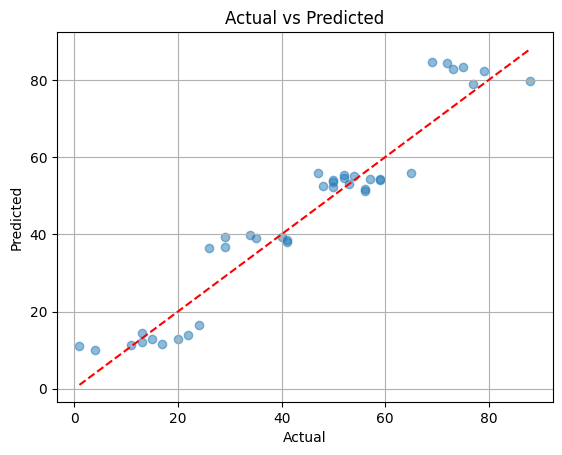

In [124]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()